In [208]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.io import loadmat

# ===============================
# Configuración
# ===============================
HIDDEN_SIZE = 32  # Aumentado para mayor capacidad
EPOCHS = 1500
LR = 5e-3  # Reducido para entrenamiento más estable
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_FRAC = 0.8  # Añadido para consistencia
print(f"Usando dispositivo: {DEVICE}")
print(f"HIDDEN_SIZE: {HIDDEN_SIZE}, LR: {LR}")


Usando dispositivo: cuda
HIDDEN_SIZE: 32, LR: 0.005


In [209]:

# ===============================
# Cargar dataset entrenamiento
# ===============================
import pandas as pd

# Leer desde CSV con separador ; y decimal ,
df = pd.read_csv("dataset14400.csv", sep=';', decimal=',')

print("Columnas disponibles:", df.columns.tolist())
print("Shape del dataframe:", df.shape)

# Convertir a numérico, eliminando valores que no se pueden parsear
u = pd.to_numeric(df['u'], errors='coerce').values
y = pd.to_numeric(df['Y'], errors='coerce').values

# Eliminar filas con NaN (números malformados)
mask = ~(np.isnan(u) | np.isnan(y))
u = u[mask]
y = y[mask]

print(f"Datos cargados: u={len(u)}, y={len(y)}")
assert len(u) == len(y), f"Longitudes diferentes: u={len(u)}, y={len(y)}"

# ===============================
# Normalización (media / varianza) -> zscore 
# ===============================
mu_u, std_u = u.mean(), u.std()
mu_y, std_y = y.mean(), y.std()

u_n = (u - mu_u) / std_u
y_n = (y - mu_y) / std_y

# ===============================
# Split temporal train/test
# ===============================
T = len(u_n)
Ttrain = int(TRAIN_FRAC * T)

u_train = u_n[:Ttrain]
y_train = y_n[:Ttrain]


Columnas disponibles: ['Y', 'u']
Shape del dataframe: (14402, 2)
Datos cargados: u=14401, y=14401


In [210]:
# ===============================
# Cargar dataset de prueba (solo para test final)
# ===============================
df_test = pd.read_csv("pruebas.csv", sep=';', decimal=',')
u_test_raw = pd.to_numeric(df_test['u'], errors='coerce').values
y_test_raw = pd.to_numeric(df_test['Y'], errors='coerce').values

# Eliminar NaN
mask_test = ~(np.isnan(u_test_raw) | np.isnan(y_test_raw))
u_test_raw = u_test_raw[mask_test]
y_test_raw = y_test_raw[mask_test]

print(f"Dataset de prueba completo: {len(u_test_raw)} muestras")

# Normalizar TODA la serie (incluyendo transitorio)
u_test_n = (u_test_raw - mu_u) / std_u

u_test_t = torch.tensor(u_test_n, dtype=torch.float32).view(1, -1, 1).to(DEVICE)

print(f"Dataset de prueba normalizado y listo")


Dataset de prueba completo: 5001 muestras
Dataset de prueba normalizado y listo


In [211]:
# ===============================
# Tensores PyTorch
# shape: (batch=1, seq_len, features=1)
# ===============================
# Usar el 80% para entrenamiento y el 20% restante del dataset 14400 para validación
train_val_split = int(0.8 * len(u_n))
u_train = u_n[:train_val_split]
y_train = y_n[:train_val_split]
u_val = u_n[train_val_split:]  # 20% del dataset 14400
y_val = y_n[train_val_split:]

u_train_t = torch.tensor(u_train, dtype=torch.float32).view(1, -1, 1).to(DEVICE)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(1, -1, 1).to(DEVICE)

u_val_t = torch.tensor(u_val, dtype=torch.float32).view(1, -1, 1).to(DEVICE)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(1, -1, 1).to(DEVICE)

print(f"Train: {len(u_train)} muestras | Val: {len(u_val)} muestras")

# ===============================
# Modelo LSTM - Arquitectura mejorada
# ===============================
class LSTMModel(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=1,
                            hidden_size=hidden_size,
                            batch_first=True,
                            dropout=0.2)  # Reducido de 0.4
        self.lstm2 = nn.LSTM(input_size=hidden_size,
                            hidden_size=hidden_size,
                            batch_first=True,
                            dropout=0.2)  # Reducido de 0.4
        self.fc = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size

    def forward(self, x, return_states=False):
        out1, (h1, c1) = self.lstm1(x)
        out2, (h2, c2) = self.lstm2(out1)
        y = self.fc(out2)
        
        if return_states:
            return y, out1, out2, h1, h2, c1, c2
        return y

model = LSTMModel(HIDDEN_SIZE).to(DEVICE)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)  # Reducido de 5e-5
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.8)  # Más suave

# ===============================
# Entrenamiento
# ===============================
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Entrenamiento
    model.train()
    optimizer.zero_grad()

    y_pred = model(u_train_t)
    train_loss = criterion(y_pred, y_train_t)

    train_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    
    train_losses.append(train_loss.item())

    # Validación (con el 20% del dataset 14400)
    model.eval()
    with torch.no_grad():
        y_val_pred = model(u_val_t)
        val_loss = criterion(y_val_pred, y_val_t)
    val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch:04d} | Train MSE = {train_loss.item():.6f} | Val MSE = {val_loss.item():.6f}")

print(f"Entrenamiento completado. Train loss final: {train_losses[-1]:.6f}, Val loss final: {val_losses[-1]:.6f}")


Train: 11520 muestras | Val: 2881 muestras
Epoch 0000 | Train MSE = 1.211231 | Val MSE = 0.206398


c:\Users\q\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 0100 | Train MSE = 0.991878 | Val MSE = 0.293988
Epoch 0200 | Train MSE = 0.201189 | Val MSE = 13.064178
Epoch 0300 | Train MSE = 0.181562 | Val MSE = 12.323597
Epoch 0400 | Train MSE = 0.135405 | Val MSE = 3.714581
Epoch 0500 | Train MSE = 0.130261 | Val MSE = 11.505562
Epoch 0600 | Train MSE = 0.119851 | Val MSE = 9.764762
Epoch 0700 | Train MSE = 0.013899 | Val MSE = 9.677429
Epoch 0800 | Train MSE = 0.008509 | Val MSE = 9.860735
Epoch 0900 | Train MSE = 0.006604 | Val MSE = 9.600041
Epoch 1000 | Train MSE = 0.005391 | Val MSE = 9.397822
Epoch 1100 | Train MSE = 0.004934 | Val MSE = 9.306691
Epoch 1200 | Train MSE = 0.004104 | Val MSE = 9.175632
Epoch 1300 | Train MSE = 0.003375 | Val MSE = 9.206388
Epoch 1400 | Train MSE = 0.002977 | Val MSE = 9.227468
Entrenamiento completado. Train loss final: 0.002653, Val loss final: 9.256188


In [212]:
# ===============================
# Predicción en dataset de prueba
# ===============================
model.eval()
with torch.no_grad():
    y_pred_n = model(u_test_t).cpu().numpy().squeeze()

# Desnormalizar
y_pred_full = y_pred_n * std_y + mu_y
y_test_full = y_test_raw.copy()

# Descartar las primeras 1000 muestras (transitorio) de AMBAS
skip = 1000
y_pred = y_pred_full[skip:]
y_test = y_test_full[skip:]

print(f"Predicción completada. {len(y_test)} muestras después de descartar transitorio")


Predicción completada. 4001 muestras después de descartar transitorio


LSTM1 shape (pruebas): (5001, 32)
LSTM2 shape (pruebas): (5001, 32)


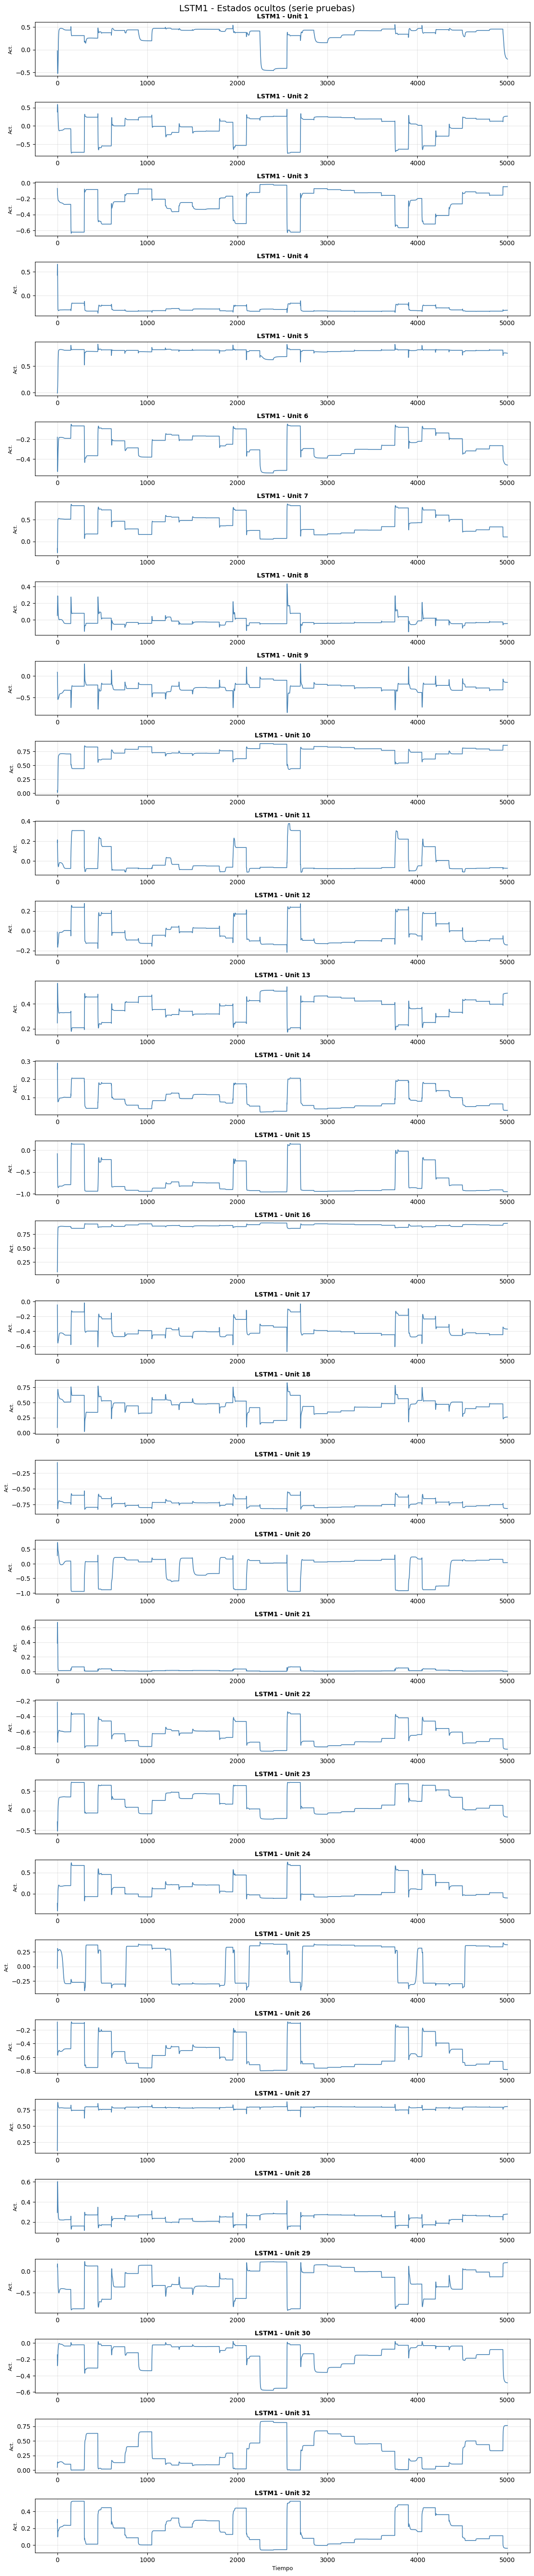

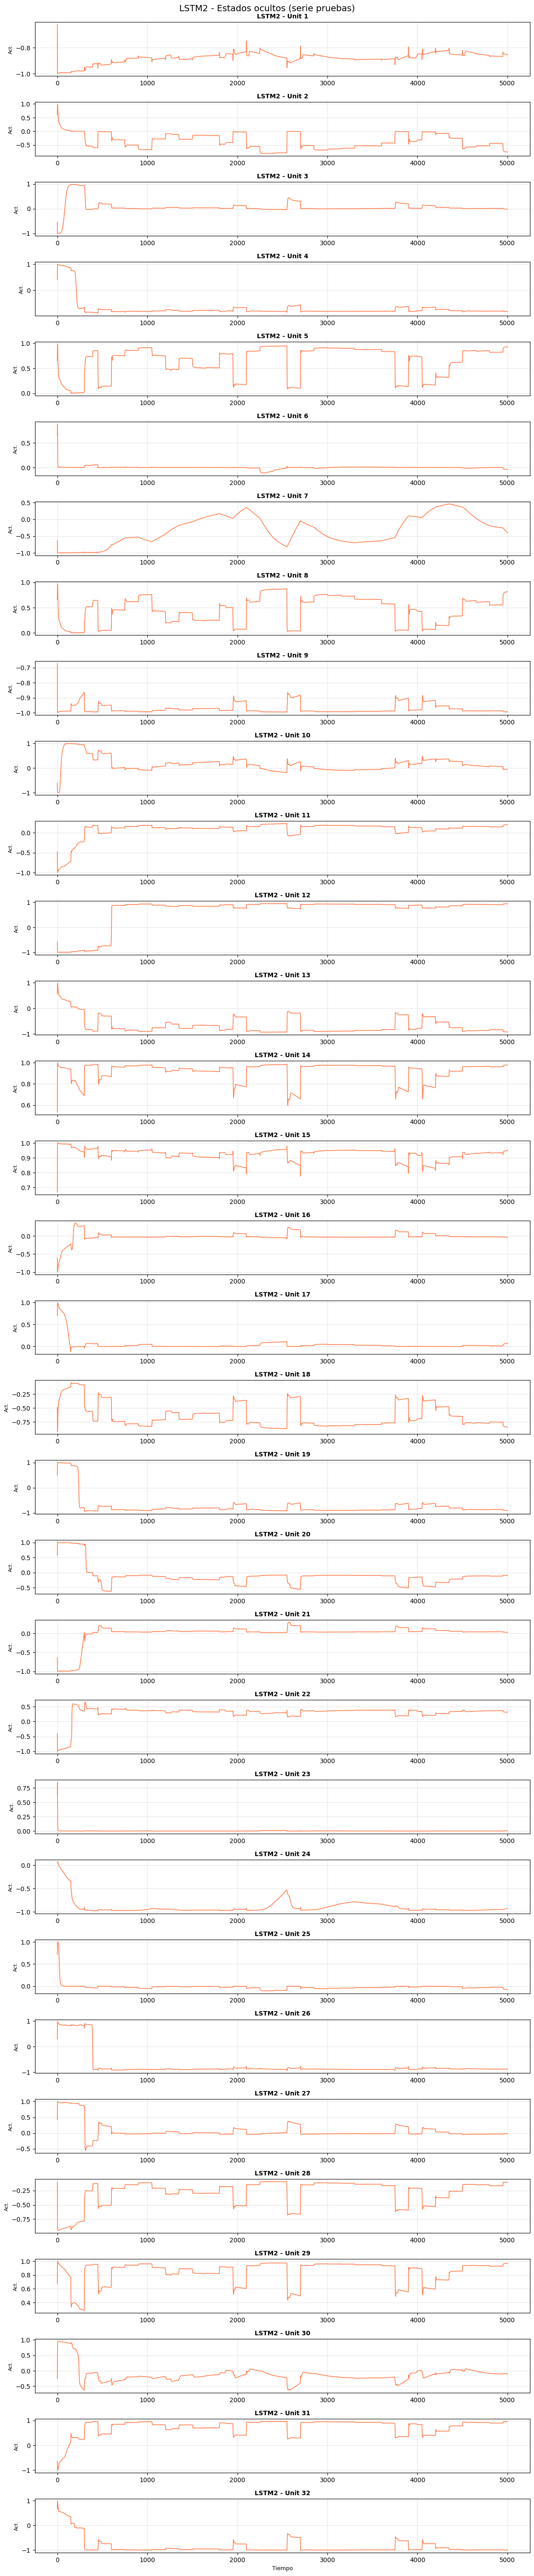

In [217]:
# ===============================
# Visualizar estados internos en el tiempo (serie pruebas)
# ===============================
model.eval()
with torch.no_grad():
    y_pred_test, out1, out2, h1, h2, c1, c2 = model(u_test_t, return_states=True)

# Convertir a numpy
out1_np = out1.squeeze().cpu().numpy()  # (seq_len, hidden_size)
out2_np = out2.squeeze().cpu().numpy()

print(f"LSTM1 shape (pruebas): {out1_np.shape}")
print(f"LSTM2 shape (pruebas): {out2_np.shape}")

# Gráfico: líneas separadas para cada unidad (1 columna - vertical)
cols = 1
rows = HIDDEN_SIZE

fig, axes = plt.subplots(rows, cols, figsize=(12, rows*1.8))

for i in range(HIDDEN_SIZE):
    axes[i].plot(out1_np[:, i], linewidth=1.2, color='steelblue')
    axes[i].set_title(f"LSTM1 - Unit {i+1}", fontsize=10, fontweight='bold')
    axes[i].grid(alpha=0.3)
    axes[i].set_ylabel("Act.", fontsize=8)

axes[HIDDEN_SIZE-1].set_xlabel("Tiempo", fontsize=9)
plt.suptitle("LSTM1 - Estados ocultos (serie pruebas)", fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(rows, cols, figsize=(12, rows*1.8))

for i in range(HIDDEN_SIZE):
    axes[i].plot(out2_np[:, i], linewidth=1.2, color='coral')
    axes[i].set_title(f"LSTM2 - Unit {i+1}", fontsize=10, fontweight='bold')
    axes[i].grid(alpha=0.3)
    axes[i].set_ylabel("Act.", fontsize=8)

axes[HIDDEN_SIZE-1].set_xlabel("Tiempo", fontsize=9)
plt.suptitle("LSTM2 - Estados ocultos (serie pruebas)", fontsize=14, y=0.995)
plt.tight_layout()
plt.show()


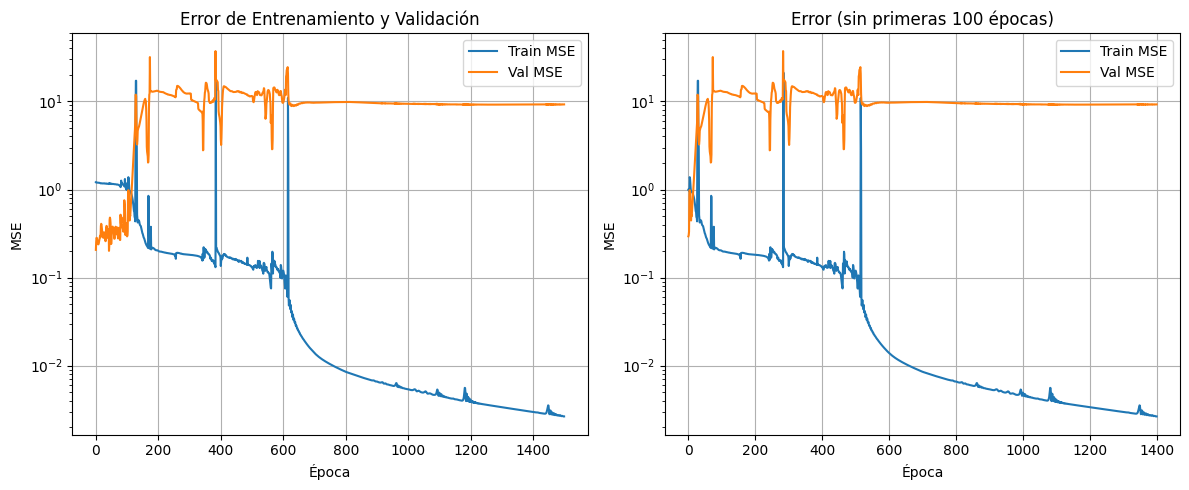

In [214]:
# ===============================
# Gráfico de pérdida (error) de entrenamiento y validación
# ===============================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train MSE", linewidth=1.5)
plt.plot(val_losses, label="Val MSE", linewidth=1.5)
plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Error de Entrenamiento y Validación")
plt.legend()
plt.grid()
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(train_losses[100:], label="Train MSE", linewidth=1.5)  # Sin primeras 100 épocas
plt.plot(val_losses[100:], label="Val MSE", linewidth=1.5)
plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Error (sin primeras 100 épocas)")
plt.legend()
plt.grid()
plt.yscale('log')

plt.tight_layout()
plt.show()



RMSE test LSTM: 0.000002
RMSE (científico): 2.222591e-06


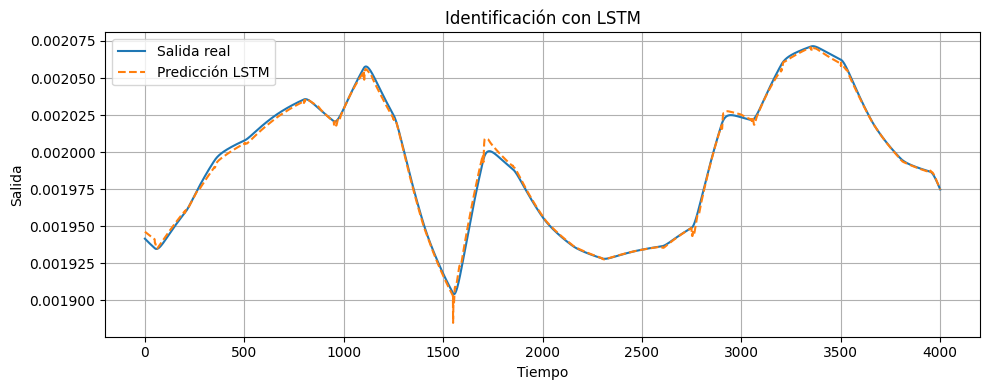

In [215]:
# ===============================
# RMSE
# ===============================
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print(f"\nRMSE test LSTM: {rmse:.6f}")
print(f"RMSE (científico): {rmse:.6e}")

# ===============================
# Gráficos
# ===============================
plt.figure(figsize=(10,4))
plt.plot(y_test, label="Salida real")
plt.plot(y_pred, label="Predicción LSTM", linestyle="--")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Salida")
plt.title("Identificación con LSTM")
plt.grid()
plt.tight_layout()
plt.show()
